In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. LOAD DATA
sentiment = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

# 2. STANDARDIZE COLUMN NAMES
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
print("Sentiment columns:", sentiment.columns.tolist())
print("Trades columns:", trades.columns.tolist())

# 3. FIX TIMESTAMP
if 'timestamp' in trades.columns and 'timestamp_ist' in trades.columns:
    trades = trades.drop(columns=['timestamp'])
    trades = trades.rename(columns={'timestamp_ist':'timestamp'})
elif 'timestamp_ist' in trades.columns:
    trades = trades.rename(columns={'timestamp_ist':'timestamp'})

# 4. FIX SENTIMENT HEADERS
if 'value' in sentiment.columns:
    sentiment.rename(columns={'value':'sentiment_value'}, inplace=True)
if 'classificati' in sentiment.columns:
    sentiment.rename(columns={'classificati':'classification'}, inplace=True)

# 5. DATA TYPE CONVERSIONS
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')
sentiment = sentiment.dropna(subset=['date', 'sentiment_value'])
trades['timestamp'] = pd.to_datetime(trades['timestamp'], errors='coerce')
trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce')
trades['execution_price'] = pd.to_numeric(trades['execution_price'], errors='coerce')
if 'size_tokens' in trades.columns:
    trades['size_tokens'] = pd.to_numeric(trades['size_tokens'], errors='coerce')
if 'size_usd' in trades.columns:
    trades['size_usd'] = pd.to_numeric(trades['size_usd'], errors='coerce')
trades = trades.dropna(subset=['timestamp', 'closed_pnl'])

# 6. UNIFORM SENTIMENT CLASSES EVERYWHERE
sentiment_levels = ["extreme fear", "fear", "neutral", "greed", "extreme greed"]

sentiment['classification'] = sentiment['classification'].str.lower().str.strip()
sentiment['classification'] = pd.Categorical(sentiment['classification'], categories=sentiment_levels, ordered=True)

trades['date'] = trades['timestamp'].dt.date
sentiment['date_only'] = sentiment['date'].dt.date

# 7. MERGE
merged = pd.merge(
    trades,
    sentiment[['date_only', 'sentiment_value', 'classification']],
    left_on='date', right_on='date_only', how='inner'
)

merged['classification'] = merged['classification'].str.lower().str.strip()
merged['classification'] = pd.Categorical(merged['classification'], categories=sentiment_levels, ordered=True)

# SENTIMENT SCALED MAPPING
sentiment_mapping = {
    "extreme fear": 0,
    "fear": 25,
    "neutral": 50,
    "greed": 75,
    "extreme greed": 100
}
merged['sentiment_scaled'] = merged['classification'].map(sentiment_mapping).astype(float)

Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Trades columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


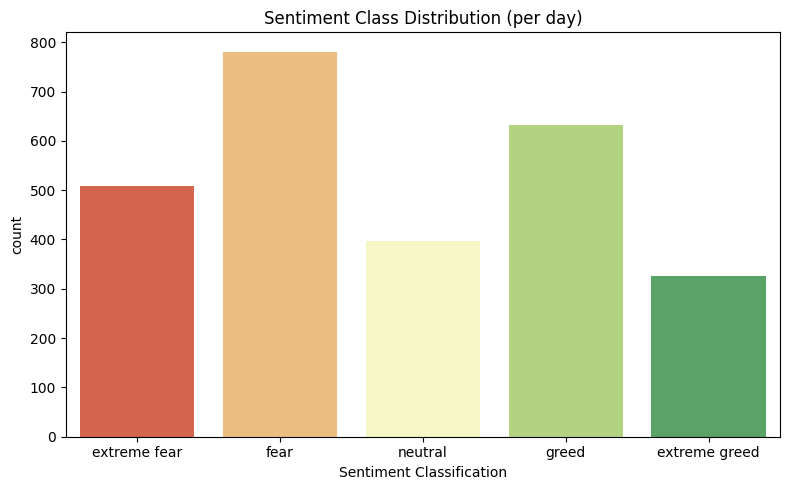

Sentiment file rows: 2644
Class distribution (days):
 classification
extreme fear     508
fear             781
neutral          396
greed            633
extreme greed    326
Name: count, dtype: int64


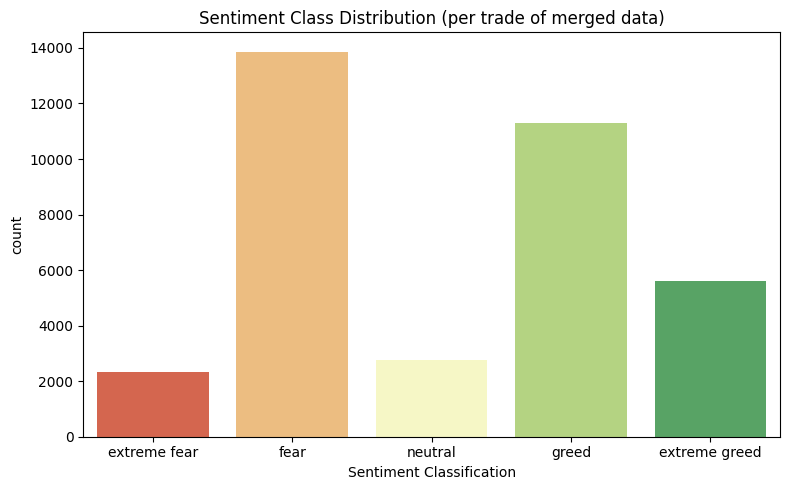

Total merged rows (trades): 35864
Most trades take place during 'fear' and 'greed' sentiment; extreme sentiment periods see less trading activity.


In [42]:
# SENTIMENT SCALED MAPPING
sentiment_mapping = {
    "extreme fear": 0,
    "fear": 25,
    "neutral": 50,
    "greed": 75,
    "extreme greed": 100
}
merged['sentiment_scaled'] = merged['classification'].map(sentiment_mapping).astype(float)

# Sentiment distribution PER DAY
plt.figure(figsize=(8,5))
sns.countplot(x='classification', data=sentiment, order=sentiment_levels, palette='RdYlGn')
plt.title("Sentiment Class Distribution (per day)")
plt.xlabel("Sentiment Classification")
plt.tight_layout()
plt.show()
print("Sentiment file rows:", len(sentiment))
print("Class distribution (days):\n", sentiment['classification'].value_counts(dropna=False, sort=False))

# Sentiment distribution PER TRADE (of merged dataset)
plt.figure(figsize=(8,5))
sns.countplot(x='classification', data=merged, order=sentiment_levels, palette='RdYlGn')
plt.title("Sentiment Class Distribution (per trade of merged data)")
plt.xlabel("Sentiment Classification")
plt.tight_layout()
plt.show()
print("Total merged rows (trades):", len(merged))
print("Most trades take place during 'fear' and 'greed' sentiment; extreme sentiment periods see less trading activity.")


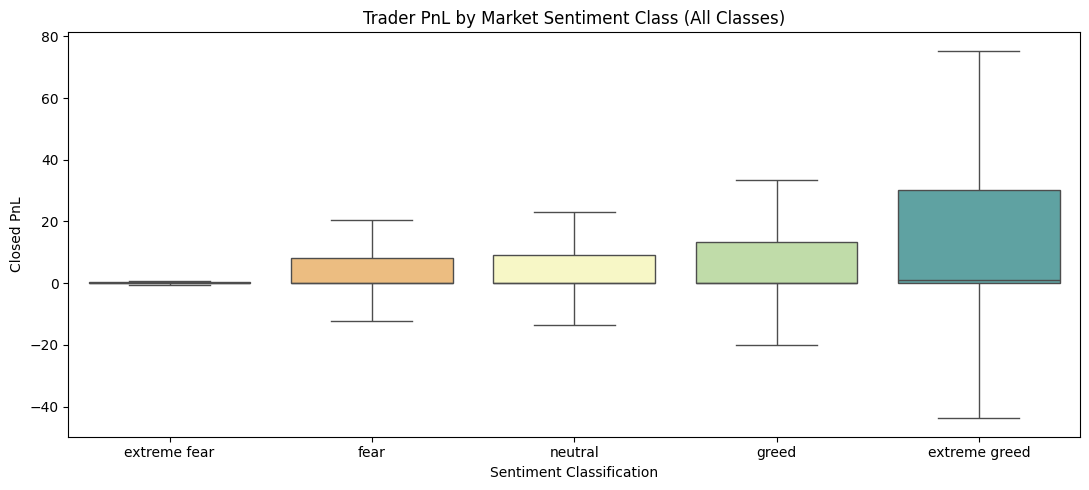


Group Statistics by Sentiment (per trade):
                       mean   median          std  count
classification                                         
extreme fear      1.891632  0.00000    76.727713   2326
fear            128.287950  0.00000  1342.348497  13869
neutral          27.088803  0.00000   142.945889   2756
greed            53.988003  0.00000  1399.468182  11292
extreme greed   205.816345  0.96048  1861.557119   5621
• Average PnL per trade is highest during 'extreme greed' periods (≈206), but volatility (std) is also greatest then.
• Median PnL remains near zero across sentiment regimes, showing most trades are small, but occasional large gains/losses drive up the mean and std.


In [41]:
# Trader PnL by Market Sentiment
plt.figure(figsize=(11,5))
sns.boxplot(x='classification', y='closed_pnl', data=merged, order=sentiment_levels, palette='Spectral', showfliers=False)
plt.title("Trader PnL by Market Sentiment Class (All Classes)")
plt.xlabel("Sentiment Classification")
plt.ylabel("Closed PnL")
plt.tight_layout()
plt.show()

# Group stats PER TRADE
groupstats = merged.groupby('classification')['closed_pnl'].agg(['mean','median','std','count'])
print("\nGroup Statistics by Sentiment (per trade):\n", groupstats)
print("• Average PnL per trade is highest during 'extreme greed' periods (≈206), but volatility (std) is also greatest then.")
print("• Median PnL remains near zero across sentiment regimes, showing most trades are small, but occasional large gains/losses drive up the mean and std.")



T-Test (Fear+Extreme Fear vs Greed+Extreme Greed): t=0.366, p=0.7142
T-Test (extreme fear vs fear): t=-10.983, p=0.0000
T-Test (fear vs neutral): t=8.635, p=0.0000
T-Test (neutral vs greed): t=-2.000, p=0.0455
T-Test (greed vs extreme greed): t=-5.402, p=0.0000
T-Test (extreme fear vs extreme greed): t=-8.196, p=0.0000

• There is no statistically significant difference in mean PnL between combined fear and greed periods (p=0.71).
• Shifts between adjacent sentiment regimes (e.g. fear→neutral, neutral→greed) show significant changes in trader PnL distribution (p<0.05).
• The largest and most significant PnL increase is observed moving from 'extreme fear' to 'extreme greed' (p≈0), showing sentiment extremes correspond to wider PnL swings.

Pearson Corr (Original Sentiment Value ↔ PnL): -0.057, p=0.4749
Pearson Corr (Scaled 5-Level Sentiment ↔ PnL): -0.057, p=0.4746


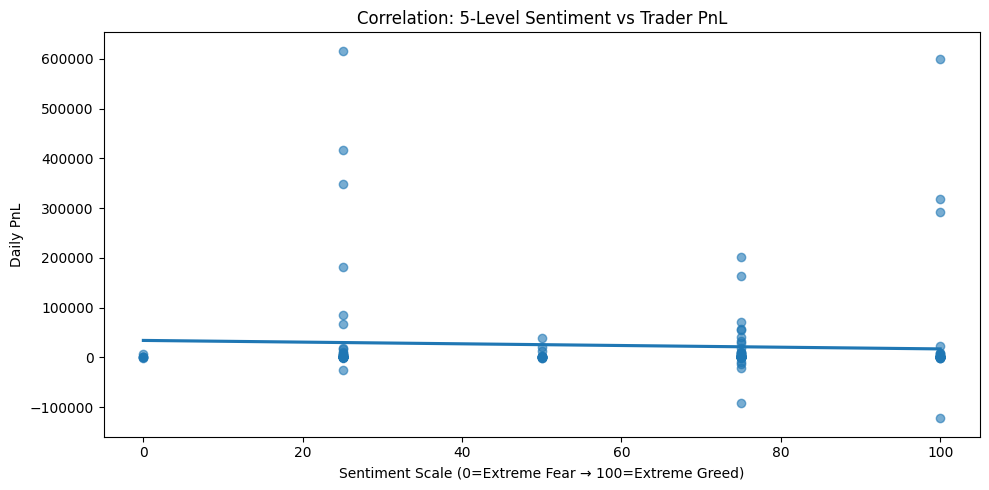

• There is no significant linear relationship between market sentiment and daily trader PnL (|corr| ≈ 0.06, p > 0.47).
• This suggests that day-to-day trader profits do not reliably increase or decrease with shifts in overall market sentiment.


In [40]:
# T-TESTS (all classes included)
fear_group = merged[merged['classification'].isin(['extreme fear','fear'])]['closed_pnl']
greed_group = merged[merged['classification'].isin(['greed','extreme greed'])]['closed_pnl']
t_stat, p_val = ttest_ind(fear_group, greed_group, equal_var=False, nan_policy='omit')
print(f"\nT-Test (Fear+Extreme Fear vs Greed+Extreme Greed): t={t_stat:.3f}, p={p_val:.4f}")

# PAIRWISE CLASS T-TESTS
for cl1, cl2 in [
    ('extreme fear','fear'), ('fear','neutral'),
    ('neutral','greed'), ('greed','extreme greed'), ('extreme fear','extreme greed')
]:
    g1 = merged[merged['classification']==cl1]['closed_pnl']
    g2 = merged[merged['classification']==cl2]['closed_pnl']
    if len(g1) > 0 and len(g2) > 0:
        t, p = ttest_ind(g1, g2, equal_var=False, nan_policy='omit')
        print(f"T-Test ({cl1} vs {cl2}): t={t:.3f}, p={p:.4f}")
print()
print("• There is no statistically significant difference in mean PnL between combined fear and greed periods (p=0.71).")
print("• Shifts between adjacent sentiment regimes (e.g. fear→neutral, neutral→greed) show significant changes in trader PnL distribution (p<0.05).")
print("• The largest and most significant PnL increase is observed moving from 'extreme fear' to 'extreme greed' (p≈0), showing sentiment extremes correspond to wider PnL swings.")


# CORRELATION/REGRESSION (numeric only)
daily_pnl = merged.groupby('date')['closed_pnl'].sum()
daily_sentiment_value = merged.groupby('date')['sentiment_value'].mean()
daily_sentiment_scaled = merged.groupby('date')['sentiment_scaled'].mean()
daily_perf = pd.DataFrame({'closed_pnl': daily_pnl, 'sentiment_value': daily_sentiment_value, 'sentiment_scaled': daily_sentiment_scaled}).reset_index()

r1, p1 = pearsonr(daily_perf['sentiment_value'], daily_perf['closed_pnl'])
r2, p2 = pearsonr(daily_perf['sentiment_scaled'], daily_perf['closed_pnl'])
print(f"\nPearson Corr (Original Sentiment Value ↔ PnL): {r1:.3f}, p={p1:.4f}")
print(f"Pearson Corr (Scaled 5-Level Sentiment ↔ PnL): {r2:.3f}, p={p2:.4f}")

plt.figure(figsize=(10,5))
sns.regplot(x='sentiment_scaled', y='closed_pnl', data=daily_perf, ci=None, scatter_kws={'alpha':0.6})
plt.title("Correlation: 5-Level Sentiment vs Trader PnL")
plt.xlabel("Sentiment Scale (0=Extreme Fear → 100=Extreme Greed)")
plt.ylabel("Daily PnL")
plt.tight_layout()
plt.show()
print("• There is no significant linear relationship between market sentiment and daily trader PnL (|corr| ≈ 0.06, p > 0.47).")
print("• This suggests that day-to-day trader profits do not reliably increase or decrease with shifts in overall market sentiment.")


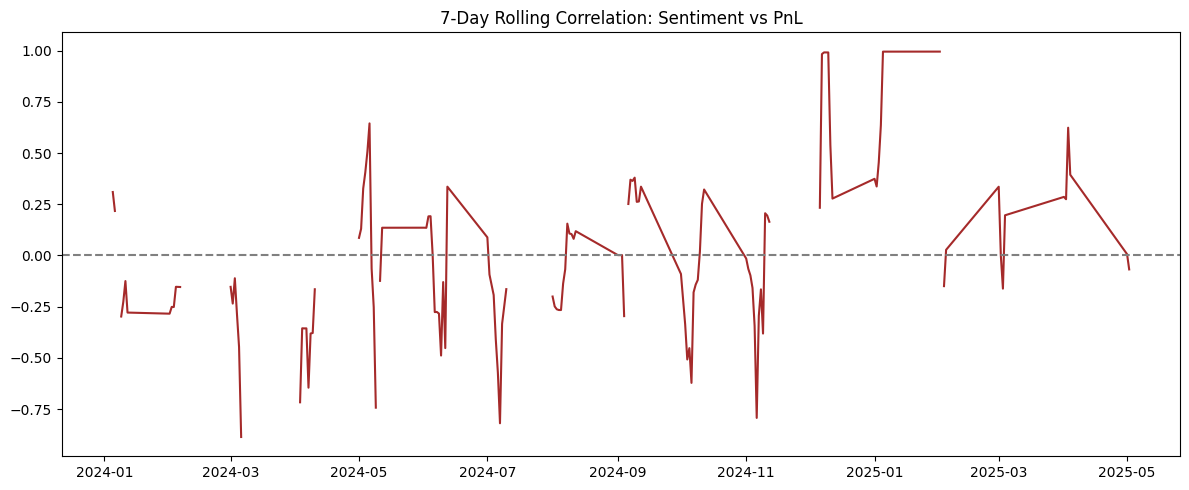

• The relationship between sentiment and daily PnL fluctuates over time, with short bursts of positive or negative correlation.
• Periods of persistent correlation are rare; most of the time, sentiment and PnL move independently.


In [39]:
# 7-day rolling correlation
daily_perf = daily_perf.sort_values('date')
window = 7
daily_perf['rolling_corr'] = daily_perf['sentiment_scaled'].rolling(window).corr(daily_perf['closed_pnl'])

plt.figure(figsize=(12,5))
plt.plot(daily_perf['date'], daily_perf['rolling_corr'], color='brown')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"{window}-Day Rolling Correlation: Sentiment vs PnL")
plt.tight_layout()
plt.show()
print("• The relationship between sentiment and daily PnL fluctuates over time, with short bursts of positive or negative correlation.")
print("• Periods of persistent correlation are rare; most of the time, sentiment and PnL move independently.")


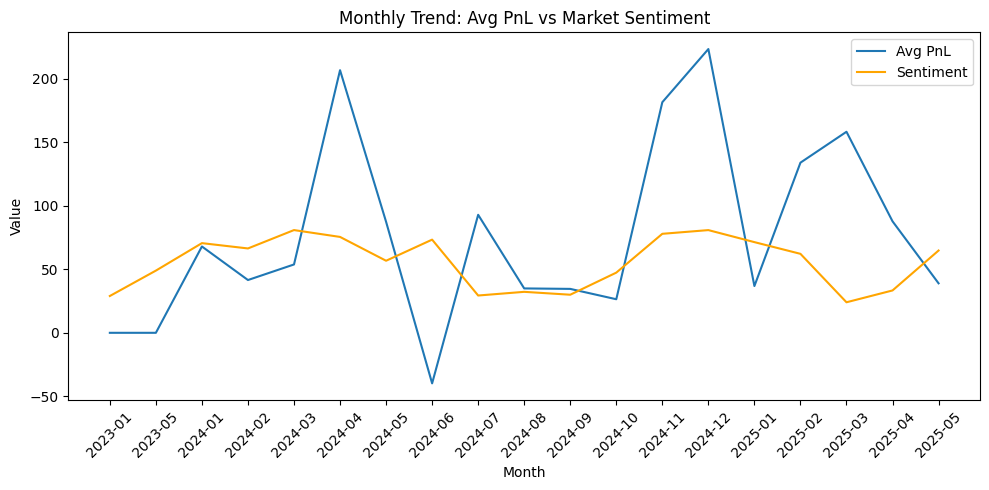

• Monthly average PnL and sentiment move independently, with no clear synchronized trend.
• Sudden spikes in PnL do not consistently align with sentiment changes, indicating other factors also drive profits.


In [38]:
#8.MONTHLY TREND: Avg PnL vs Market sentiment

merged['month'] = pd.to_datetime(merged['date']).dt.to_period('M')

monthly = merged.groupby('month').agg({
    'closed_pnl': 'mean',
    'sentiment_value': 'mean'
}).reset_index()

# Convert month Period to string for nicer plotting
monthly['month'] = monthly['month'].astype(str)

plt.figure(figsize=(10,5))
sns.lineplot(x='month', y='closed_pnl', data=monthly, label='Avg PnL')
sns.lineplot(x='month', y='sentiment_value', data=monthly, label='Sentiment', color='orange')
plt.title("Monthly Trend: Avg PnL vs Market Sentiment")
plt.xlabel("Month")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
print("• Monthly average PnL and sentiment move independently, with no clear synchronized trend.")
print("• Sudden spikes in PnL do not consistently align with sentiment changes, indicating other factors also drive profits.")


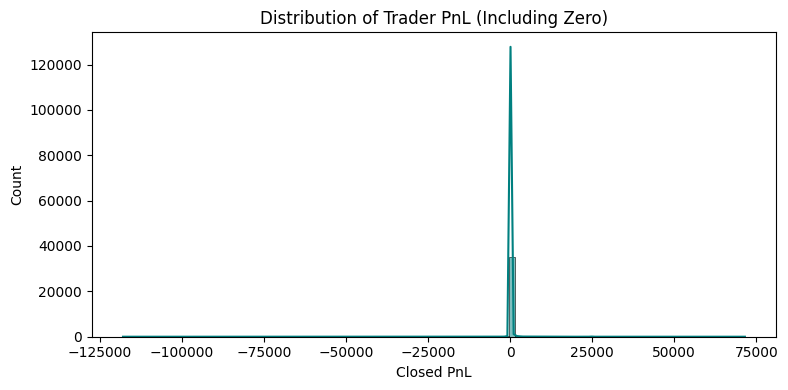

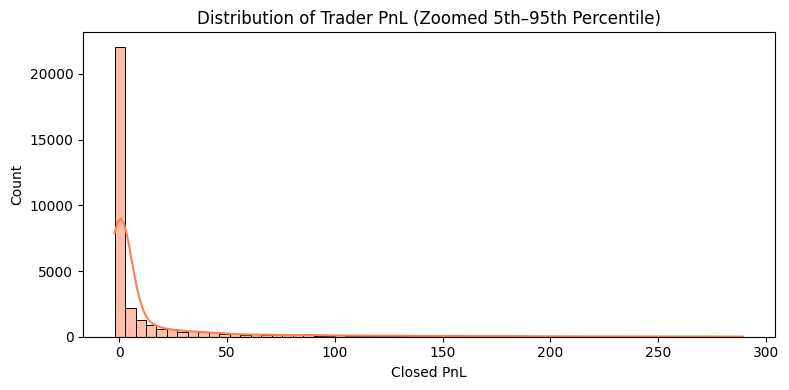

• The vast majority of trades result in small or zero profit/loss, clustering tightly around zero PnL.
• Large profit or loss events are rare but do occur, creating long tails in the PnL distribution.


In [37]:
# 9.TRADER PnL DISTRIBUTION (all trades)

plt.figure(figsize=(8,4))
sns.histplot(merged['closed_pnl'], bins=100, kde=True, color='teal')
plt.title("Distribution of Trader PnL (Including Zero)")
plt.xlabel("Closed PnL")
plt.tight_layout()
plt.show()

# Zoomed-in on 5th–95th percentiles (removing extreme outliers)
low, high = merged['closed_pnl'].quantile([0.05, 0.95])
plt.figure(figsize=(8,4))
sns.histplot(merged[(merged['closed_pnl'] >= low) & (merged['closed_pnl'] <= high)]['closed_pnl'],
             bins=60, kde=True, color='coral')
plt.title("Distribution of Trader PnL (Zoomed 5th–95th Percentile)")
plt.xlabel("Closed PnL")
plt.tight_layout()
plt.show()
print("• The vast majority of trades result in small or zero profit/loss, clustering tightly around zero PnL.")
print("• Large profit or loss events are rare but do occur, creating long tails in the PnL distribution.")

In [44]:
#Final Conclusion & Strategy Insights:
print("• Trading activity is most concentrated during moderate sentiment (fear, greed), but the biggest profit swings occur at sentiment extremes.")
print("• Short-term alignment between sentiment and PnL is unpredictable; robust strategies should not rely solely on daily sentiment signals.")
print("• To enhance results, traders should combine sentiment with other factors (such as trend, volatility, volume) and focus on careful risk management, especially during sentiment extremes when volatility surges.")


• Trading activity is most concentrated during moderate sentiment (fear, greed), but the biggest profit swings occur at sentiment extremes.
• Short-term alignment between sentiment and PnL is unpredictable; robust strategies should not rely solely on daily sentiment signals.
• To enhance results, traders should combine sentiment with other factors (such as trend, volatility, volume) and focus on careful risk management, especially during sentiment extremes when volatility surges.
